In [1]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union, make_pipeline, Pipeline
from sklearn.model_selection import ParameterGrid

from sklearn.impute import MissingIndicator, KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler

from fenginering.function import *
from fenginering.indicator import *
from fenginering.transformer import *
from fenginering.preprocessing import Crossover
from fenginering.preprocessing import Scale
from data.get_data import *

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.pipeline import FeatureUnion

In [3]:
start = "2022"
end = "2023"
data = get_data('BTC', '1h').loc[start : end]
data.drop(columns = ['symbol'], inplace = True)
data.columns = data.columns.astype(str)
data.shape

(11282, 5)

In [4]:
data['target'] = get_classification_target(data)
data = data.iloc[:-1]

In [5]:
lag_ret_list = [0, 1, 3, 5, 9, 15, 30]
ema_list = [3, 9, 15]
rsi_list = [10, 14, 20]

atr_list = [10, 20, 25, 30, 48, 72]

macd_dict = {
    'slow' : [10, 14],
    'fast' : [3, 5],
    'signal' : [2, 3]
}

sar_dict = {
    'step' : [0.2],
    'max_step' : [0.2]
}

stochastic_oscillator_dict = {
    'k_period' : [10, 15, 20],
    'd_period' : [3, 5]
}

Indicators = MakeIndicator(data)

Indicators.set_stransformer(lag_returns, lag_ret_list)
Indicators.set_stransformer(rsi, rsi_list)
Indicators.set_mtransformer(stochastic_oscillator, stochastic_oscillator_dict)
Indicators.set_stransformer(atr, atr_list)

data = Indicators.get_data()
n_drop = Indicators.na_count
        
norm_scale = Scale(data)
data = norm_scale.transform()

In [6]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

<AxesSubplot: >

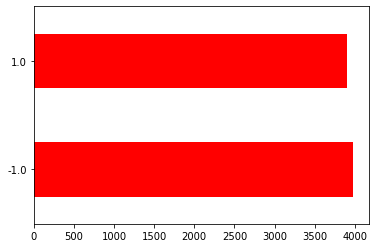

In [7]:
N = data.shape[0]
n = int(0.7*N)
train = data[:n]
test = data[n:]

features, target = train.drop(columns = ['target']), train['target']
features_test, target_test = test.drop(columns = ['target']), test['target']


target.value_counts().plot(kind = 'barh', color = 'red')

In [8]:
from sklearn.model_selection import TimeSeriesSplit

exp_cv = TimeSeriesSplit(n_splits = 10)

In [ ]:
model = RandomForestClassifier()
model.fit(features, target)

In [ ]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier()
model_xgb.fit(features, target)

In [9]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(features, target)

c:\Users\cc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
from evaluation.curve import learningCurve
from sklearn.model_selection import TimeSeriesSplit

exp_cv = TimeSeriesSplit(n_splits = 10)
#learningCurve(model, features, target, exp_cv)

In [ ]:
y_pred = model.predict(features_test)
y_pred_proba = model.predict_proba(features_test)

from evaluation.classification import *

evaluation = Evaluation(y_true = target_test, y_pred = y_pred, proba_pred = y_pred_proba[:,1])
evaluation.metrics()
evaluation.show()

 Accuracy : 0.55 
 f1 : 0.53 
 precision : 0.57 
 recall : 0.50 
 AUC : 0.57 
              precision    recall  f1-score   support

        -1.0       0.53      0.60      0.56      1627
         1.0       0.57      0.50      0.53      1749

    accuracy                           0.55      3376
   macro avg       0.55      0.55      0.55      3376
weighted avg       0.55      0.55      0.55      3376



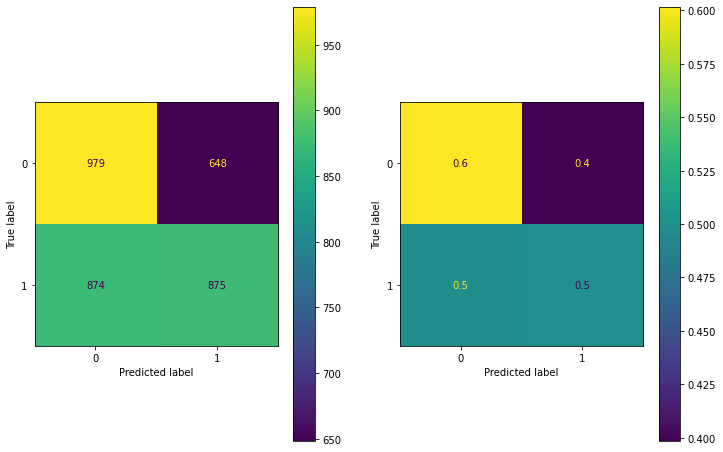

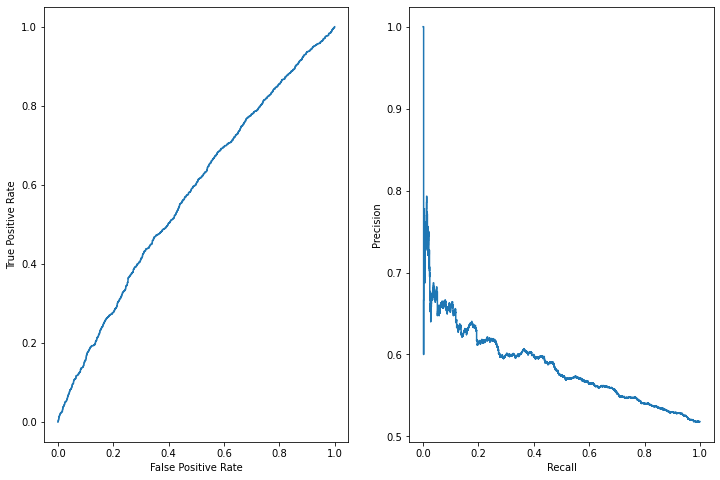

In [10]:
y_pred = model_lr.predict(features_test)
y_pred_proba = model_lr.predict_proba(features_test)

from evaluation.classification import *

evaluation = Evaluation(y_true = target_test, y_pred = y_pred, proba_pred = y_pred_proba[:,1])
evaluation.metrics()
evaluation.show()

In [ ]:
import plotly.express as px
px.box(y_pred_proba)

In [ ]:
Importance = pd.DataFrame({'Importance' : model.feature_importances_*100},
                          index = model.feature_names_in_)
Importance.sort_values('Importance', axis = 0, ascending = True).plot(kind = 'barh', color = 'r')

In [ ]:

up = 0.68
down = 0.36

y_pred = model_xgb.predict(features_test)
y_pred_proba = model_xgb.predict_proba(features_test)

from evaluation.classification import *

evaluation = Evaluation(y_true = target_test, y_pred = y_pred, proba_pred = y_pred_proba[:,1])
evaluation.metrics()
evaluation.show()


In [ ]:
import plotly.express as px
px.box(y_pred_proba)

In [ ]:
import joblib
#joblib.dump(model, 'model_file/model.joblib')
#joblib.dump(model_xgb, 'model_file/model_xgb.joblib')

# backtest

In [ ]:
def backtest(features_test, target_test):
    backtest = pd.DataFrame()
    #backtest['close'] = features_test.close
    #backtest['returns'] = features_test.close.pct_change()
    backtest['returns'] = features_test.ret_1_0
    backtest['target'] = target_test
    backtest['pred'] = y_pred
    backtest['pred_proba'] = y_pred_proba[:,0]

    backtest['pred2'] = np.where(backtest['pred_proba'] > 0.7, 1,
            np.where(backtest['pred_proba'] < 0.3, -1, 0)
            )

    backtest['cum_ret'] = (1 + backtest['returns']).cumprod()

    backtest['strategy'] = backtest['returns']*backtest['pred']
    backtest['strategy2'] = backtest['returns']*backtest['pred2']
    
    backtest['strategy_cum_ret'] = (1 + backtest['strategy']).cumprod()
    backtest['strategy_cum_ret2'] = (1 + backtest['strategy2']).cumprod()
    
    backtest[['cum_ret', 'strategy_cum_ret', 'strategy_cum_ret2']].plot(figsize = (15, 10))
    

In [ ]:
backtest(features_test, target_test)

In [ ]:
lev = 10

up = 0.55
down = 0.45

backtest = pd.DataFrame()

#backtest['close'] = features_test.close
#backtest['returns'] = features_test.close.pct_change()
backtest['returns'] = features_test.ret_1_0
backtest['target'] = target_test
backtest['pred'] = y_pred
backtest['pred_proba'] = y_pred_proba[:,0]

backtest['pred2'] = np.where(backtest['pred_proba'] > 0.7, 1,
         np.where(backtest['pred_proba'] < 0.3, -1, 0)
         )

backtest['cum_ret'] = (1 + backtest['returns']).cumprod()

backtest['strategy'] = backtest['returns']*backtest['pred']
backtest['strategy_cum_ret'] = (1 + backtest['strategy']).cumprod()

backtest['leverage'] = np.where(backtest['pred_proba'] > 0.8, lev,
                                np.where(backtest['pred_proba'] < 0.2, lev, 1)
                                )
backtest['strategy2'] = backtest['returns'] * backtest['pred2'] * backtest['leverage']


backtest['strategy_cum_ret2'] = (1 + backtest['strategy2']).cumprod()

#backtest

#backtest[['cum_ret', 'strategy_cum_ret', 'strategy_cum_ret2']].plot(figsize = (15, 10))
px.line(backtest[['cum_ret', 'strategy_cum_ret', 'strategy_cum_ret2']])

In [ ]:
px.box(backtest[['strategy', 'strategy2']])

In [ ]:
backtest['pred2'] = np.where(backtest['pred_proba'] > 0.7, 1,
         np.where(backtest['pred_proba'] < 0.3, -1, 0)
         )

backtest['pred2'].iloc[:100].value_counts()

In [ ]:
px.line(backtest['pred2'].iloc[:100])